In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math

%matplotlib inline

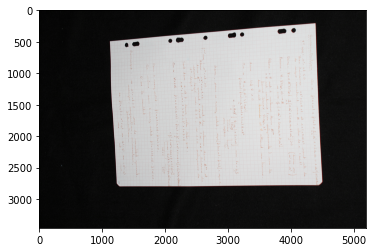

In [60]:
#img0 = cv2.imread('./_data/raw/canon 1/IMG_1052.JPG')
#right_contour = 0
#rotation = -90

img0 = cv2.imread('./_data/categorized/simple/IMG_1086.JPG')
right_contour = 0
rotation = 90

#img0 = cv2.imread('./_data/raw/canon 3/IMG_1156.JPG')
#right_contour = 0
#rotation = -90

plt.imshow(img0)

# Image rotation

## Using scipy

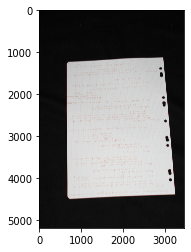

In [61]:
img1 = ndimage.rotate(img0, -90)
plt.imshow(img1)

## Using opencv

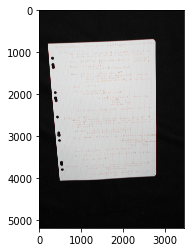

In [62]:
def rotateAboutCenter(src, angle, scale=1.):
    """Rotate an image by a given angle."""
    w = src.shape[1]
    h = src.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle)*h) + abs(np.cos(rangle)*w))*scale
    nh = (abs(np.cos(rangle)*h) + abs(np.sin(rangle)*w))*scale
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw*0.5, nh*0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw-w)*0.5, (nh-h)*0.5,0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0,2] += rot_move[0]
    rot_mat[1,2] += rot_move[1]
    return cv2.warpAffine(src, rot_mat,
                          (int(math.ceil(nw)), int(math.ceil(nh))),
                         flags=cv2.INTER_LANCZOS4)

img1 = ndimage.rotate(img0, rotation)
plt.imshow(img1)

# Contour detection.

The following is based on these two pages:
 * http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html
 * http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html


## How to find the contour that goes around the page?

Three strategies:
 * First contour:
   * not always as proved by './_data/categorized/simple/IMG_1086.JPG' for which it is the fourth one
 * Contour with the most points:
   * not always as proved by './_data/raw/canon 3/IMG_1156.JPG' for which it is the first one (not the longuest one)
 * Contour with the longuest segment:
   * Always work so far...

Proposal (not implemented, for the time being the contours with longuest segment is working fine):
 * Filter out contours (not approximated contour) that do not end close to where they started.
 * Filter out **approximated** contours which do not have exactly 4 points.
 * Filter out **approximated** contours that have small segments (e.g. less than 1/3 of smaller dimension of the page).
 * Select contour with longuest segments in average

## High level analysis of the contour

Contours:
 - number of contours:  229
 - num of points in first contours:  4
 - contours[0]:  [[[ 318 2804]] [[ 318 2807]] [[ 319 2806]] [[ 319 2804]]]
 - first point of contours[0]:  [ 318 2804]
 - last point of contours[0]:  [ 319 2804]
Approximated contours:
 - number of approximated contours:  186
 - num of points in first approximated contour:  4
 - approximated contours[0]:  [[[2725  694]] [[ 211  802]] [[ 499 4059]] [[2794 3906]]]
 - first point of approximated contours[0]:  [2725  694]
 - last point of approximated contours[0]:  [2794 3906]


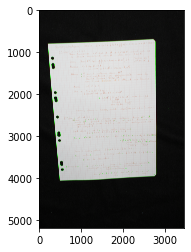

In [10]:
imgray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray, 127, 255, 0)

contours, hierarchy = cv2.findContours(thresh,
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)

print("Contours:")
print(" - number of contours: ", len(contours))
print(" - num of points in first contours: ", len(contours[0]))
print(" - contours[0]: ", str(contours[0]).replace('\n', ''))
print(" - first point of contours[0]: ", contours[0][0][0])
print(" - last point of contours[0]: ", contours[0][-1][0])


# Approximate contours (and filter out the ones that are too small)
# todo: remove from contours the one that do not close.
appContours = [cv2.approxPolyDP(cnt,
                                0.1*cv2.arcLength(cnt, True),
                                True)
               for cnt in contours
               if len(cnt) >= 4]
appContours = [cnt for cnt in appContours if len(cnt) >= 4]

print("Approximated contours:")
print(" - number of approximated contours: ", len(appContours))
print(" - num of points in first approximated contour: ", len(appContours[0]))
print(" - approximated contours[0]: ", str(appContours[0]).replace('\n', ''))
print(" - first point of approximated contours[0]: ", appContours[0][0][0])
print(" - last point of approximated contours[0]: ", appContours[0][-1][0])



imgt = img1.copy()
cv2.drawContours(imgt, contours, -1, (0,255,0), 3)
plt.imshow(imgt)

## First contour

True

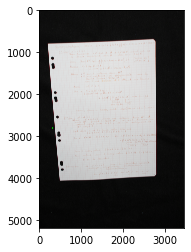

In [11]:
def findFirstContour(contours):
    return 0
    
imgt = img1.copy()
cv2.drawContours(imgt, [contours[findFirstContour(contours)]], -1, (0,255,0), 30)
plt.imshow(imgt)
cv2.imwrite('out.jpg', imgt)

## Contour with the most points

Looking at contour with max number of points
 - Index of contour with max number of points:  3


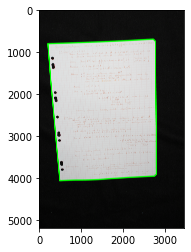

In [12]:
def findContourWithMostPoints(contours):
    lengths = [len(cnt) for cnt in contours]
    longest = max(lengths)
    ilonguest = lengths.index(longest)
    return ilonguest

iLonguest = findContourWithMostPoints(contours)

print("Looking at contour with max number of points")
print(" - Index of contour with max number of points: ", iLonguest)

imgt = img1.copy()
cv2.drawContours(imgt, [contours[iLonguest]], -1, (0,255,0), 30)
plt.imshow(imgt)
#cv2.imwrite('out.jpg', imgt)

## Contour with longuest segment

Best contour is in position 0
 - segment lengths of best contour:  [2516.3187397466163, 3269.7083967840313, 2300.094345891055, 3212.7410415406966]


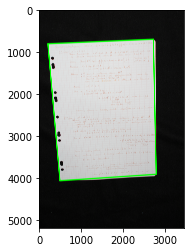

In [13]:
def segmentLength(contour):
    c = contour.tolist()
    seglens = [math.sqrt((x2-x1)**2+(y2-y1)**2)
               for ([[[x1, y1]], [[x2, y2]]])
               in zip(c,
                      c[1:]+c[:1])]
    return seglens

def findContourWithLonguestSegment(contours):
    # Find contour with longuest segment
    maxi = 0
    index = -1
    for i, contour in enumerate(contours):
        # Compute segment lengths
        seglens = segmentLength(contour)
        longuest = max(seglens)
        # If this is the contour with the longuest segment
        if longuest > maxi:
            maxi = longuest
            index = i
    return index

iContourLonguestSegment = findContourWithLonguestSegment(appContours)
print("Best contour is in position {}".format(iContourLonguestSegment))
print(" - segment lengths of best contour: ", segmentLength(appContours[0]))


imgt = img1.copy()
cv2.drawContours(imgt, [appContours[iContourLonguestSegment]], -1, (0,255,0), 30)
plt.imshow(imgt)
#cv2.imwrite('out.jpg', imgt)

# Matching the contour points

Let's match the point of the contour.
First one is the top left corners, then trigo order.

In [14]:
approx = appContours[iContourLonguestSegment]
print("Approximated contour =", str(approx).replace('\n', ''))

v = [i[0][0]+i[0][1] for i in approx]
topleft = v.index(min(v))
print("point at top left is number {}".format(topleft))

v = [i[0][0]-i[0][1] for i in approx]
bottomleft = v.index(min(v))
print("point at bottom left is number {}".format(bottomleft))

v = [i[0][0]+i[0][1] for i in approx]
bottomright = v.index(max(v))
print("point at bottom right is number {}".format(bottomright))

v = [i[0][0]-i[0][1] for i in approx]
topright = v.index(max(v))
print("point at top right is number {}".format(topright))

ordered_indexes = [topleft, bottomleft, bottomright, topright]
print("ordered index", ordered_indexes)

ordered_contour = np.array([approx[i] for i in ordered_indexes])
print("ordered contour: ", str(ordered_contour).replace("\n", ""))


Approximated contour = [[[2725  694]] [[ 211  802]] [[ 499 4059]] [[2794 3906]]]
point at top left is number 1
point at bottom left is number 2
point at bottom right is number 3
point at top right is number 0
ordered index [1, 2, 3, 0]
ordered contour:  [[[ 211  802]] [[ 499 4059]] [[2794 3906]] [[2725  694]]]


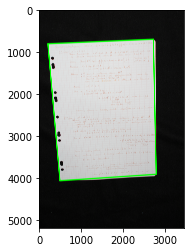

In [15]:
imgt = img1.copy()
cv2.drawContours(imgt, [ordered_contour], -1, (0,255,0), 30)
plt.imshow(imgt)
#cv2.imwrite("out1.jpg", imgt)


# Determine 'A4' zone

In [17]:
def computeA4subarea(img):
    """Return the dimension (rows, cols) of the biggest subarea
    of the image that would have the same proportion than an
    A4 page."""
    rows, cols, ch = img.shape
    rowsA4, colsA4 = 297, 210
    newrows, newcols = rows, cols
    if 1.0*rows/cols > rowsA4/colsA4:
        newrows = int(1.0 * cols * rowsA4 / colsA4)
    else:
        newcols = int(1.0 * rows * colsA4 / rowsA4)
    return newrows, newcols

rows, cols, ch = img1.shape
print("image dimension:    ", rows, cols)
newrows, newcols = computeA4subarea(img1)
print("proposed dimension: ", newrows, newcols)


image dimension:     5184 3456
proposed dimension:  4887 3456


# Changement of perspective

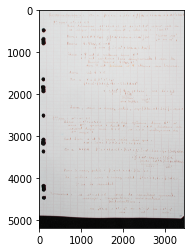

In [18]:
# The points that will define the transformation
pts_origin = np.float32(ordered_contour)
pts_destination = np.float32([[0,0],
                              [0,newrows],
                              [newcols,newrows],
                              [newcols,0]
                              ])

# Apply the transformation
M = cv2.getPerspectiveTransform(pts_origin, pts_destination)
img2 = cv2.warpPerspective(img1, M, (cols,rows))

cv2.imwrite("out2.jpg", img2)

plt.imshow(img2)

# Crop the image

4887 3456
(5184, 3456, 3)
(4887, 3456, 3)


True

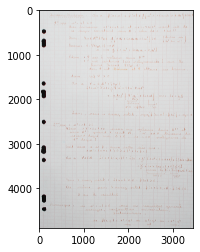

In [20]:
print(newrows, newcols)
print(img2.shape)

img3 = img2[0:newrows, 0:newcols]

print(img3.shape)
plt.imshow(img3)

cv2.imwrite("out3.jpg", img3)


# Detect a black picture

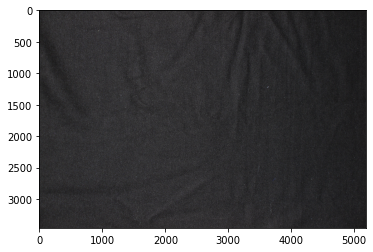

In [21]:
imgblack0 = cv2.imread('./_data/categorized/black/IMG_1141.JPG')
plt.imshow(imgblack0)

In [24]:
rows, cols, ch = imgblack0.shape

print(rows, cols)
for y in range(int(rows/4), rows, int(rows/4)):
    for x in range(int(cols/4), cols, int(cols/4)):
        print(x, y, imgblack0[y, x])

3456 5184
1296 864 [49 48 50]
2592 864 [54 54 54]
3888 864 [39 38 42]
1296 1728 [45 41 47]
2592 1728 [44 39 48]
3888 1728 [54 54 54]
1296 2592 [50 49 51]
2592 2592 [48 47 51]
3888 2592 [45 50 41]


864 1221 [224 224 224]
1728 1221 [225 227 227]
2592 1221 [226 226 226]
864 2442 [217 218 218]
1728 2442 [211 211 211]
2592 2442 [213 205 206]
864 3663 [213 213 213]
1728 3663 [209 207 207]
2592 3663 [185 173 169]
864 4884 [197 197 197]
1728 4884 [203 203 203]
2592 4884 [198 202 202]


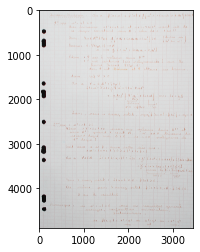

In [25]:
plt.imshow(img3)

rows, cols, ch = img3.shape

for y in range(int(rows/4), rows, int(rows/4)):
    for x in range(int(cols/4), cols, int(cols/4)):
        print(x, y, img3[y, x])
        


In [27]:
def isBlack(img):
    rows, cols, ch = img.shape
    sumb = sumt = 0
    div = 10
    for y in range(int(rows/div), rows, int(rows/div)):
        for x in range(int(cols/div), cols, int(cols/div)):
            rgb = img[y, x]
            if rgb[0] < 100 and rgb[1] < 100 and rgb [2] < 100:
                sumb += 1
            sumt += 1
    return 1.0 * sumb / sumt > 0.9

print("mainly white:", isBlack(img3))
print("white in the middle:", isBlack(img0))
print("mainly black:", isBlack(imgblack0))

mainly white: False
white in the middle: False
mainly black: True


In [38]:
import os


paths = ['./_data/categorized/black',
         './_data/categorized/simple']

for path in paths:
    print("\n", path, ": ")
    for imgfile in os.listdir(path):
        if imgfile[-4:].lower() != ".jpg":
            continue
        im = cv2.imread(os.path.join(path, imgfile))
        print(isBlack(im), " ", end='')
        



 ./_data/categorized/black : 
True  True  True  True  True  True  
 ./_data/categorized/simple : 
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  

# Build PDF file

In [47]:
#bytes = img2pdf("./_data/canon/IMG_1052.JPG", dpi=150)

import img2pdf

path = './_data/categorized/simple'
images = os.listdir(path)
images = [os.path.join(path, i) for i in images]
print(images)


with open("tempo.pdf", "wb") as f:
    f.write(img2pdf.convert(images))

#pdf_bytes = img2pdf.convert(images, dpi=25)
#file = open("name.pdf","wb")
#file.write(pdf_bytes)
#file.close()

#print help(img2pdf.convert)

['./_data/categorized/simple/IMG_1108.JPG', './_data/categorized/simple/IMG_1120.JPG', './_data/categorized/simple/IMG_1097.JPG', './_data/categorized/simple/IMG_1096.JPG', './_data/categorized/simple/IMG_1121.JPG', './_data/categorized/simple/IMG_1094.JPG', './_data/categorized/simple/IMG_1095.JPG', './_data/categorized/simple/IMG_1122.JPG', './_data/categorized/simple/IMG_1091.JPG', './_data/categorized/simple/IMG_1090.JPG', './_data/categorized/simple/IMG_1127.JPG', './_data/categorized/simple/IMG_1125.JPG', './_data/categorized/simple/IMG_1119.JPG', './_data/categorized/simple/IMG_1086.JPG', './_data/categorized/simple/IMG_1092.JPG', './_data/categorized/simple/IMG_1093.JPG', './_data/categorized/simple/IMG_1087.JPG', './_data/categorized/simple/IMG_1118.JPG', './_data/categorized/simple/IMG_1100.JPG', './_data/categorized/simple/IMG_1128.JPG', './_data/categorized/simple/IMG_1102.JPG', './_data/categorized/simple/IMG_1089.JPG', './_data/categorized/simple/IMG_1088.JPG', './_data/c

# Build a new image

(596, 842, 3)

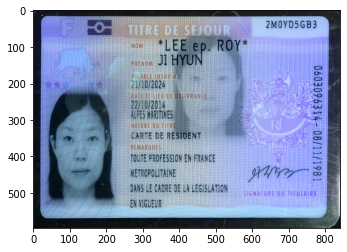

In [48]:
imgts0 = cv2.imread('./_data/raw/titre sejour/1.jpg')
imgts0 = rotateAboutCenter(imgts0, 90, scale=1.)
plt.imshow(imgts0)

imgts0.shape

(596, 842, 3)

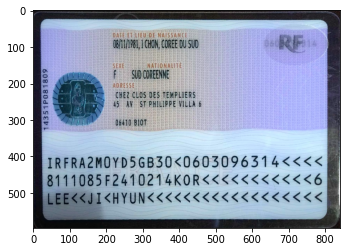

In [49]:
imgts1 = cv2.imread('./_data/raw/titre sejour/2.jpg')
imgts1 = rotateAboutCenter(imgts1, 90, scale=1.)
plt.imshow(imgts1)

imgts1.shape

Create an empty "white" image:

1890 2673


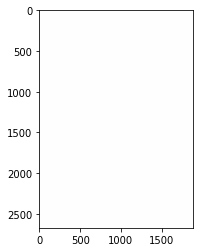

In [55]:
# Dimension of the card in cm
tsYmm, tsXmm = 54, 85
# Dimension of the scan of the card in mm
tsYpx, tsXpx, ch = imgts0.shape
# Dimension of an A4 page in mm
a4Ymm, a4Xmm = 297, 210

# Dimension of an A4 page matching the definition of the scan of the card.
a4Xpx = a4Xmm * int(tsXpx/tsXmm)
a4Ypx = a4Ymm * int(tsXpx/tsXmm)

print(a4Xpx, a4Ypx)

img = np.empty(a4Xpx*a4Ypx*3,
               dtype=int).reshape(a4Ypx,
                                  a4Xpx, 3)
img.fill(254)
plt.imshow(img)


True

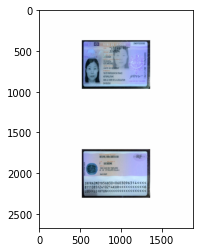

In [57]:
# Add first image in the middle of the top half
y0 = int(a4Ypx/4 - tsYpx/2)
x0 = int(a4Xpx/2 - tsXpx/2)
img[y0:y0+imgts0.shape[0], x0:x0+imgts0.shape[1], 0:3] = imgts0

# Add second image in the middle of the bottom half
y1 = int(3*a4Ypx/4 - tsYpx/2)
img[y1:y1+imgts1.shape[0], x0:x0+imgts1.shape[1], 0:3] = imgts1

plt.imshow(img)
cv2.imwrite('titresejour.jpg', img)

In [58]:
pdf_bytes = img2pdf.convert(["titresejour.jpg"], dpi=25)

file = open("titre sejour.pdf","wb")
file.write(pdf_bytes)
file.close()
